In [1]:
import math, pickle, glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.linewidth'] = 0.8

saveformat = '.eps' # or ''
dpi = 1200
paramtitle = False

In [ ]:
one_label_one_data = False
workspace = 'noisy'
label     = 'noisy_normal3'
figlabel = workspace

targeton = False

label_dir = '../data/{}/{}/'.format(workspace,label)
wild_dir  = '../data/{}/{}/*.pickle'.format(workspace,label)

list_for_lpwise_dicts = []

count = 0

label_list = glob.glob(label_dir)
for label in label_list:
    data_list = glob.glob(label+'*.pickle')
    for data_path in data_list:
        with open(data_path, 'rb') as f:
            hyperdict  = pickle.load(f)
            lpwise_dict = pickle.load(f)
            list_for_lpwise_dicts.append((hyperdict, lpwise_dict))
            count += 1 
        if one_label_one_data:
            break
    
print('{} data were loaded.'.format(count))

algo = hyperdict['algo']
T, T_save, loop, k, p = hyperdict['T'], hyperdict['T_save'] ,hyperdict['loop'], hyperdict['k'], hyperdict['p']
sigma, delta = hyperdict['sigma'], hyperdict['delta']
learning_param_list = np.asarray(hyperdict['lp_list'])

#Gamma selection
allgamma = [x[0]['gamma'] for x in list_for_lpwise_dicts]

#target = np.asarray([0.0, 0.006, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1]) * delta
target = np.asarray([0.0, 0.00001, 0.00003, 0.00005]) * delta

targetidx = []
for idx, gamma in enumerate(allgamma):
    if np.any(np.isclose(gamma, target)) or (not targeton):
        targetidx.append(idx)
list_for_lpwise_dicts = [list_for_lpwise_dicts[idx] for idx in targetidx]

        
print([x[0]['gamma'] for x in list_for_lpwise_dicts])

if algo == 'noisy':
    noisy_lpwise_dicts = list_for_lpwise_dicts
    noisy_param_list   = learning_param_list
elif algo == 'oja':
    oja_lpwise_dicts = list_for_lpwise_dicts
    oja_param_list   = learning_param_list
else:
    raise NotImplementedError

print('Hyper Dictionary Sample: ')
for k,v in hyperdict.items():
    print('{}: {}'.format(k,v))

In [140]:
if algo == 'oja':
    ojadict  =  list_for_lpwise_dicts
    oja_param_list = learning_param_list
elif algo == 'noisy':
    noisydict = list_for_lpwise_dicts
    noisy_param_list = learning_param_list
else:
    print('NotImplemented')

## Convergence Graph

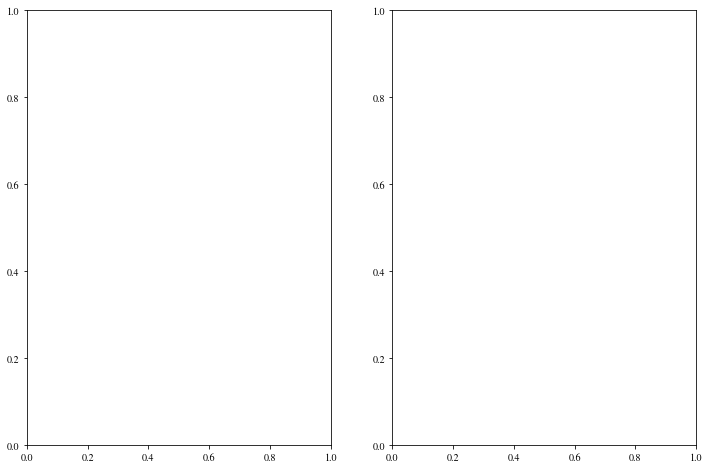

In [145]:
fig = plt.figure(figsize=(12,8),facecolor=(1, 1, 1))
ax_noisy = fig.add_subplot(1, 2, 1)
ax_oja   = fig.add_subplot(1, 2, 2)
markers = ['o','h','s','^']
sizes = [150,180,150,150]

# Basic settings
#ub = 0.4

# For \delta plot
ub = 0.3

trim = True
sparselabel = False #0, 3, 7... 만 label 부여
save = True
paramtitle=False

## Noisy Power Method

In [146]:
colors = pl.cm.copper(np.linspace(0,0.8,len(noisydict)))
print(colors)

noisydict = sorted(noisydict, key=lambda v: (v[0]['p'],-v[0]['delta'],v[0]['gamma'],v[0]['k']))

for c, (hyperdict, datadict_list) in enumerate(noisydict):
    
    lp_xaxis = np.copy(noisy_param_list)

    # Extract Data
    dist_array = np.zeros((loop,len(lp_xaxis)))    
    for repeat,datadict in enumerate(datadict_list):

        for lp_idx,lp in enumerate(lp_xaxis):
            dist_array[repeat,lp_idx] = np.average(datadict[lp][len(datadict[lp])//3:])
    
    #dist_array = np.flip(dist_array,axis=1) if algo=='oja' else dist_array
    
    # Set Label
    #label_str = r'$(\Gamma,\delta,p)=({:.0e},{:.1f},{})$'.format(hyperdict['gamma'],hyperdict['delta'],hyperdict['p'])
    #label_str = r'$\Gamma={:.0e}$'.format(hyperdict['gamma'])
    
    # For \delta plot
    label_str = r'$\delta={:.1f}$'.format(hyperdict['delta'])
        
    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    
    print('label={}, min={}'.format(label_str,np.min(avg)))
    
    # Trim unconverged data
    
    if trim:
        if np.where(avg<ub)[0].size != 0:
            args = np.where(avg<ub)[0]
            #print(args)
            lp_xaxis = lp_xaxis[args]
            avg, std = avg[args], std[args]
        
    # Plot line
    if sparselabel:
        label_str = label_str if c%4==1 else '_nolegend_'
    
    ax_noisy.plot(lp_xaxis,avg,ls='--',linewidth=2,color=colors[c],zorder=1)
    ax_noisy.errorbar(lp_xaxis,avg,std,fmt='none', ecolor=colors[c],elinewidth=2,capsize=0,zorder=2)
    
    # Plot marker 
    signlist = np.ones(len(lp_xaxis))
    arg = np.argmin(avg)
    signlist[arg+1:] = -1
    for jdx, sign in enumerate(signlist):
        marker_s = (markers[c],sizes[c]) if sign==1 else (markers[c],sizes[c]*0.75)
        color_s  = ('none',colors[c]) if sign==1 else (colors[c],'white')
        if jdx == 0:
            ax_noisy.scatter(lp_xaxis[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],color=color_s[1],edgecolors=color_s[0],linewidths=2,\
                           label=label_str,zorder=3)
        else:
            ax_noisy.scatter(lp_xaxis[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],color=color_s[1],edgecolors=color_s[0],linewidths=2,zorder=3)
            
if paramtitle:
    title = 'Noisy Power Method'+r', $(\delta,\,\sigma,\,p/k)=({:.1f},\,{:.2f},\,{:d})$'.format(delta, sigma, p//k)
    titlesize = 28
else:
    title = 'Noisy Power Method'
    titlesize = 36
ax_noisy.set_title(title,fontsize=titlesize,pad=15)
        
ax_noisy.set_xlim(5,20000)
ax_noisy.set_xticks([10.0,100.0,1000.0,10000,10000,10000])
ax_noisy.set_xticklabels([r'$10^{1}$',r'$10^{2}$',r'$10^{3}$',r'$10^{4}$','',''],fontsize=24)
ax_noisy.set_ylim(0.00,ub*1.05)
ax_noisy.set_yticks([0.0,0.1,0.2,0.3])
ax_noisy.set_yticklabels([0.0,0.1,0.2,0.3],fontsize=24)

ax_noisy.set_xlabel(r'Block Size $B$',fontsize=28,labelpad=5)
#ax_noisy.set_ylabel(r'$||\,U_{k\!\!+\!\!1\!:\!p}\,\,{\hat{U}_{1\!:\!k}^{\,\top}}\,||_2$',fontsize=28,labelpad=15)
ax_noisy.set_ylabel(r'$d({U}_{1\!:\!k}\,,\hat{U}_{1\!:\!k})$',fontsize=28,labelpad=15)
ax_noisy.set_xscale("log")

ax_noisy.legend(loc="upper left",bbox_to_anchor=(-0.04,0.26), fontsize=18,frameon=False,ncol=1)

[[0.         0.         0.         1.        ]
 [0.32941169 0.20832    0.13266667 1.        ]
 [0.65882337 0.41664    0.26533333 1.        ]
 [0.98823506 0.62496    0.398      1.        ]]
label=$\delta=8.0$, min=0.013707216289348477
label=$\delta=4.0$, min=0.021145362900649733
label=$\delta=2.0$, min=0.03412540685015211
label=$\delta=1.0$, min=0.05429195537698844


## Oja's Algorithm

In [147]:
colors = pl.cm.bone(np.linspace(0,0.85,len(ojadict)))
print(colors)

ojadict = sorted(ojadict, key=lambda v: (v[0]['p'],-v[0]['delta'],v[0]['gamma'],v[0]['k']))

for c, (hyperdict, datadict_list) in enumerate(ojadict):

    lp_xaxis = np.copy(oja_param_list)
    
    # Extract Data
    dist_array = np.zeros((loop,len(lp_xaxis)))    
    for repeat,datadict in enumerate(datadict_list):

        for lp_idx,lp in enumerate(lp_xaxis):
            dist_array[repeat,lp_idx] = np.average(datadict[lp][-30:])
        print(repeat)
    
    #dist_array = np.flip(dist_array,axis=1) if algo=='oja' else dist_array
    
    # Set Label
    #label_str = r'$(\Gamma,\delta,p)=({:.0e},{:.1f},{})$'.format(hyperdict['gamma'],hyperdict['delta'],hyperdict['p'])
    #label_str = r'$\Gamma={:.0e}$'.format(hyperdict['gamma'])
    
    # For \delta plot
    label_str = r'$\delta={:.1f}$'.format(hyperdict['delta'])
        
    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    
    print('label={}, min={}'.format(label_str,np.min(avg)))
    
    # Trim unconverged data
    
    if trim:
        if np.where(avg<ub)[0].size != 0:
            args = np.where(avg<ub)[0]
            #print(args)
            lp_xaxis = lp_xaxis[args]
            avg, std = avg[args], std[args]
        
    # Plot line
    if sparselabel:
        label_str = label_str if c%4==1 else '_nolegend_'
    
    ax_oja.plot(lp_xaxis,avg,ls='--',linewidth=2,color=colors[c],zorder=1)
    ax_oja.errorbar(lp_xaxis,avg,std,fmt='none', ecolor=colors[c],elinewidth=2,capsize=0,zorder=2)
    
    signlist = np.ones(len(lp_xaxis))
    arg = np.argmin(avg)
    signlist[arg+1:] = -1
    for jdx, sign in enumerate(signlist):
        marker_s = (markers[c],sizes[c]) if sign==1 else (markers[c],sizes[c]*0.75)
        color_s   = ('none',colors[c]) if sign==1 else (colors[c],'white')
        if jdx == 0:
            ax_oja.scatter(lp_xaxis[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],color=color_s[1],edgecolors=color_s[0],linewidths=2,\
                           label=label_str,zorder=3)
        else:
            ax_oja.scatter(lp_xaxis[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],color=color_s[1],edgecolors=color_s[0],linewidths=2,zorder=3)


if paramtitle:
    title = 'Oja\'s Algorithm'+r', $(\delta,\,\sigma,\,p/k)=({:.1f},\,{:.2f},\,{:d})$'.format(delta, sigma, p//k)
    titlesize = 28
else:
    title = 'Oja\'s Algorithm'
    titlesize = 36
ax_oja.set_title(title,fontsize=titlesize,pad=15)
        
ax_oja.set_xlim(1.0/20000.0,1.0/5.0)
ax_oja.set_xticks([1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0e-1,1.0e-1])
ax_oja.set_xticklabels([r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$',r'$10^{1}$','',''],fontsize=24)
ax_oja.set_xscale("log")
ax_oja.invert_xaxis()
ax_oja.set_ylim(0.00,ub*1.05)
ax_oja.set_yticks([0.0,0.1,0.2,0.3])
ax_oja.set_yticklabels(['','','',''],fontsize=24)

ax_oja.set_xlabel(r'Learning Rate $\zeta$',fontsize=28,labelpad=5)

ax_oja.legend(loc="upper left",bbox_to_anchor=(-0.04,0.26), fontsize=18,frameon=False,ncol=1)

[[0.         0.         0.         1.        ]
 [0.24705882 0.24705873 0.34373402 1.        ]
 [0.49754902 0.56433819 0.62254893 1.        ]
 [0.79626218 0.86960784 0.86960781 1.        ]]
label=$\delta=8.0$, min=0.01344660629296346
label=$\delta=4.0$, min=0.021185843586534154
label=$\delta=2.0$, min=0.03459712683629876
label=$\delta=1.0$, min=0.053712499240422346


In [148]:
fig.tight_layout()
fig.savefig('../figs/'+'noisy_oja'+saveformat,dpi=dpi)

# E.O.D